# Dealing with noisy data

Cross-validated methods to separate high-dimensional signal from noise

TODO

In [2]:
# TODO uncomment before final packaging
# %pip install git+https://github.com/BonnerLab/ccn-tutorial.git


In [3]:
from collections.abc import Sequence
import functools
import warnings
from typing import NamedTuple

import numpy as np
import pandas as pd
import xarray as xr
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import ipywidgets as widgets
from IPython.display import display

from utilities.brain import load_dataset

from utilities.computation import assign_logarithmic_bins


In [4]:
%matplotlib inline

sns.set_theme(
    context="notebook",
    style="white",
    palette="deep",
    rc={"legend.edgecolor": "None"},
)
set_matplotlib_formats("svg")

pd.set_option("display.max_rows", 5)
pd.set_option("display.max_columns", 10)
pd.set_option("display.precision", 3)
pd.set_option("display.show_dimensions", False)

xr.set_options(display_max_rows=3, display_expand_data=False)

warnings.filterwarnings("ignore")

In [5]:
random_state = 0
rng = np.random.default_rng(seed=random_state)


## Neural data is noisy

Experimental data is noisy – often fundamentally. When we measure neural
activity in response to a stimulus, our recordings comprise several
sources of variation:

-   intrinsic stochasticity in the system – e.g. the stochastic spiking
    of neurons
-   measurement noise
    -   e.g.scanner drift in fMRI
    -   e.g. poor electrode scalp contact in EEG
-   cross-trial variation – i.e. recording responses to the same stimuli
    from the same animal on multiple days
    -   e.g. when your participant has coffee in the morning before a
        long scanning session
    -   e.g. in brain-computer intefaces, where representational shifts
        require the system to be recalibrated frequently
-   cross-individual differences – i.e. recording from different
    participants in an experiment
-   stimulus-dependent signal
    -   e.g. face-selective neurons in the fusiform face area responding
        more to faces than houses

Of these sources of variation, when investigating a sensory system, we
are typically interested in the last one – how the neural response
varies with the stimulus.

### Truncating spectra might ignore low-variance signal!

In the last section, we observed that neural responses have
high-dimensional structure, as evidenced by the covariance spectrum
obtained from principal component analysis. How much of this variance is
driven by stimulus-dependent signal – and how much is noise? The typical
assumption when applying principal component analysis as a
dimensionality reduction tool is that high-variance dimensions
correspond to *signal* in the system, while low-variance dimensions
represent *noise*. However, there is no fundamental reason this has to
be the case!

For example, consider a *very realistic* scenario where a participant
gets bored performing our experiment inside an fMRI scanner and starts
yodeling to entertain themselves. The highest variance components in the
measured neural response would likely be motion artifacts and not
whatever signal we were interested in measuring. A high-quality data
preprocessing pipeline would help mitigate such extreme components of
variance – but cannot remove them entirely!

In fact, as we saw when we inspected the first couple of latent
dimensions in our toy example, the principal components didn’t
correspond directly to the latent variables generating the data; rather,
they were a mixture of stimulus-dependent variance and nuisance
variance.

This suggests that using principal component analysis as a
dimensionality reduction tool by setting an arbitrary variance threshold
is likely too stringent a criterion: there is possible low-variance
signal along the many neglected dimensions in the tail!

Clearly, we need a different approach to using the spectrum to separate
signal and noise…

> **The covariance structure of random matrices**
>
> Even random matrices have some covariance structure that result in
> non-zero eigenvalues. This structure has been mathematically
> characterized by the [Marchenko-Pastur
> distribution](https://en.wikipedia.org/wiki/Marchenko-Pastur_distribution).
> This makes it especially difficult to infer anything about the
> reliability or significance of the dimension from the magnitude of the
> eigenvalue – especially when the eigenvalues are close to zero.
>
> ``` python
> def simulate_marchenko_pastur(
>     n_stimuli: int = 500,
>     n_neurons: int = 500,
>     n_repetitions: int = 50,
> ) -> np.ndarray:
>     data = rng.standard_normal((n_repetitions, n_stimuli, n_neurons))
>     data -= data.mean(axis=-2, keepdims=True)
>
>     singular_values = np.linalg.svd(data, compute_uv=False)
>     return (
>         xr.DataArray(
>             name="eigenvalue",
>             data=singular_values**2 / (n_stimuli - 1),
>             dims=("repetition", "rank"),
>             coords={"rank": ("rank", 1 + np.arange(singular_values.shape[-1]))},
>         )
>         .to_dataframe()
>         .reset_index()
>     )
>
>
> def view_marchenko_pastur(eigenvalues: xr.DataArray, *, log: bool = False) -> None:
>     fig, ax = plt.subplots()
>     sns.lineplot(
>         ax=ax,
>         data=eigenvalues,
>         x="rank",
>         y="eigenvalue",
>         estimator="mean",
>         errorbar="sd",
>         err_style="band",
>     )
>     if log:
>         ax.set_xscale("log")
>         ax.set_yscale("log")
>         ax.set_ylim(bottom=1e-2)
>
>     sns.despine(ax=ax, offset=20)
>     fig.show()
>
>
> eigenvalues = simulate_marchenko_pastur()
> view_marchenko_pastur(eigenvalues)
> ```
>
> 

## Cross-validated PCA

In a whole-brain calcium-imaging study where mice viewed 2,800 natural
images while neural responses were recorded, Stringer et al. (2021)
developed cross-validated PCA (CV-PCA) as a method to reliably estimate
the covariance structure of the neural responses. Since each image was
viewed twice, these repetitions could be used as train/test splits to
estimate covariance eigenvalues. Specifically, eigenvectors are computed
on a training set of data, and *cross-validated* eigenvalues are
computed by computing the covariance between two independent sets of
data:

$$
\begin{align*}
    \text{cov}(X_\text{train}, X_\text{train})
    &= X_\text{train}^\top X_\text{train} / (n - 1)\\
    &= V \Lambda V^\top
$$



$$
    \Lambda_\text{cross-validated}
    &= \text{cov}(X_\text{train}V, X_\text{test}V)\\
    &= \left( X_\text{train} V \right) ^\top \left( X_\text{test} V \right) / (n - 1)
\end{align*}
$$

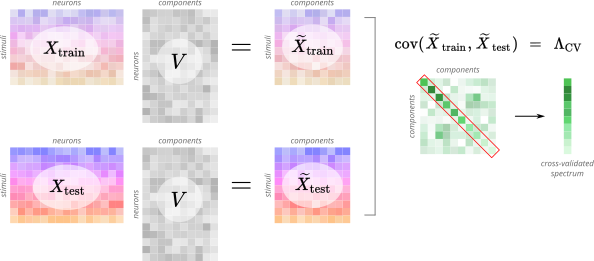

These cross-validated eigenvalues represent the covariance reliably
shared across two presentations of the visual stimulus – which is a
quantity we are interested in as neuroscientists: what is the “stable”
part of the visual representation of a natural image? Notably, these
“eigenvalues” need not be positive: if there is no shared covariance
between the two systems at a rank, the expected value of the eigenvalue
is $0$.

### Some geometric intuition

### A computational recipe

In [7]:
class CrossValidatedPCA:
    def __init__(self) -> None:
        return

    def __call__(self, /, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        self.pca = PCA()
        self.pca.fit(x)
        x_transformed = self.pca.transform(x)
        y_transformed = self.pca.transform(y)

        cross_covariance = np.cov(
            x_transformed,
            y_transformed,
            rowvar=False,
        )

        self.cross_validated_spectrum = np.diag(
            cross_covariance[: self.pca.n_components_, self.pca.n_components_ :]
        )


### Analyzing neural data

Let’s apply CV-PCA to our fMRI data to see what it looks like!

In [8]:
data = load_dataset(subject=0, roi="general").load()

display(data)


<xarray.DataArray 'fMRI betas' (presentation: 1400, neuroid: 15724)>
-0.2375 -0.4001 -0.7933 0.04382 -0.1157 ... 0.2669 -1.051 -0.179 0.03348 -0.2664
Coordinates: (3/8)
 x (neuroid) uint8 12 12 12 12 12 12 12 ... 71 72 72 72 72 72 72
 y (neuroid) uint8 21 22 22 22 22 22 23 ... 34 29 29 30 30 30 31
 ... ...
 rep_id (presentation) uint8 0 0 0 0 0 0 1 0 0 0 ... 0 0 1 1 1 1 1 1 1
Dimensions without coordinates: presentation, neuroid
Attributes: (3/7)
 resolution: 1pt8mm
 preprocessing: fithrf_GLMdenoise_RR
 ... ...
 citation: Allen, E.J., St-Yves, G., Wu, Y. et al. A massive 7T fMRI... xarray.DataArray 'fMRI betas' presentation : 1400 neuroid : 15724 -0.2375 -0.4001 -0.7933 0.04382 ... -1.051 -0.179 0.03348 -0.2664 array([[-0.23748732, -0.4000817 , -0.79332644, ..., 0.34429136,
 -0.8983028 , -1.1036999 ],
 [ 0.60243624, -1.5812274 , -1.0527056 , ..., -0.63479644,
 -0.54893786, 0.38300768],
 [ 0.12001861, 1.5943868 , 0.11450057, ..., 0.36619487,
 0.02145388, 0.9037204 ],
 ...,
 [ 0.4122271 , -1.9848806 , -1.4696951 , ..., 1.1890962 ,
 0.10346738, -0.18423374],
 [-0.32920593, 0.44030157, 0.02951132, ..., 1.1662561 ,
 1.2881701 , 0.96182734],
 [-0.04278437, -0.8031657 , -0.45526204, ..., -0.17902693,
 0.03348494, -0.26644066]], dtype=float32) Coordinates: (8) x (neuroid) uint8 12 12 12 12 12 ... 72 72 72 72 72 array([12, 12, 12, ..., 72, 72, 72], dtype=uint8) y (neuroid) uint8 21 22 22 22 22 ... 29 30 30 30 31 array([21, 22, 22, ..., 30, 30, 31], dtype=uint8) z (neuroid) uint8 47 45 46 47 48 ... 46 45 46 49 49 array([47, 45, 46, ..., 46, 49, 49], dtype=uint8) stimulus_id (presentation) object 'image46002' ... 'image52596' array(['image46002', 'image48617', 'image44980', ..., 'image34186',
 'image45356', 'image52596'], dtype=object) session_id (presentation) uint8 0 0 0 0 0 0 0 ... 26 26 26 26 26 26 array([ 0, 0, 0, ..., 26, 26, 26], dtype=uint8) trial (presentation) uint16 0 28 35 44 55 ... 681 684 714 744 array([ 0, 28, 35, ..., 684, 714, 744], dtype=uint16) run_id (presentation) uint8 0 0 0 0 0 0 1 ... 9 10 10 10 11 11 array([ 0, 0, 0, ..., 10, 11, 11], dtype=uint8) rep_id (presentation) uint8 0 0 0 0 0 0 1 0 ... 0 1 1 1 1 1 1 1 array([0, 0, 0, ..., 1, 1, 1], dtype=uint8) Indexes: (0) Attributes: (7) resolution : 1pt8mm preprocessing : fithrf_GLMdenoise_RR z_score : True roi : general subject : 0 brain shape : [ 81 104 83] citation : Allen, E.J., St-Yves, G., Wu, Y. et al. A massive 7T fMRI dataset to bridge cognitive neuroscience and artificial intelligence. Nat Neurosci 25, 116-126 (2022). https://doi.org/10.1038/s41593-021-00962-x

Note that the data contain fMRI responses to two repetitions of each
image.

In [9]:
data_repetition_1 = data.isel({"presentation": data["rep_id"] == 0}).sortby(
    "stimulus_id"
)
data_repetition_2 = data.isel({"presentation": data["rep_id"] == 1}).sortby(
    "stimulus_id"
)

cv_pca = CrossValidatedPCA()
cv_pca(data_repetition_1.values, data_repetition_2.values)


In [10]:
def plot_cross_validated_spectrum(
    cv_pca: CrossValidatedPCA,
    *,
    log: bool = False,
    original: bool = False,
    square: bool = False,
    bin_logarithmically: bool = False,
) -> mpl.figure.Figure:
    fig, ax = plt.subplots()

    data = pd.DataFrame(
        {
            "rank": 1 + np.arange(len(cv_pca.cross_validated_spectrum) - 1),
            "cross-validated": cv_pca.cross_validated_spectrum[:-1],
            "original": cv_pca.pca.explained_variance_[:-1],
        }
    ).melt(
        id_vars=["rank"],
        value_vars=["cross-validated", "original"],
        value_name="eigenvalue",
        var_name="spectrum",
    )

    if original:
        sns.lineplot(
            ax=ax,
            data=data,
            x="rank",
            y="eigenvalue",
            hue="spectrum",
        )
    else:
        data = (
            data.loc[data["spectrum"] == "cross-validated"]
            .rename(columns={"eigenvalue": "cross-validated eigenvalue"})
            .drop(columns="spectrum")
        )

        if bin_logarithmically:
            data["rank"] = assign_logarithmic_bins(
                data["rank"], points_per_bin=5, min_=1, max_=10_000
            )

            sns.lineplot(
                ax=ax,
                data=data,
                x="rank",
                y="cross-validated eigenvalue",
                marker="o",
                dashes=False,
                ls="None",
                err_style="bars",
                estimator="mean",
                errorbar="sd",
            )
        else:
            sns.lineplot(
                ax=ax,
                data=data,
                x="rank",
                y="cross-validated eigenvalue",
            )

    if log:
        ax.axhline(0, ls="--", c="gray")
        ax.set_xlim(left=1)
        ax.set_ylim(bottom=1e-2)
        ax.set_xscale("log")
        ax.set_yscale("log")

        if square:
            ax.axis("square")

    sns.despine(ax=ax)
    plt.close(fig)

    return fig


plot_cross_validated_spectrum(cv_pca)


In [11]:
plot_cross_validated_spectrum(cv_pca, log=True)


In [12]:
plot_cross_validated_spectrum(cv_pca, log=True, original=True)


In [13]:
with sns.axes_style("whitegrid"):
    fig = plot_cross_validated_spectrum(
        cv_pca, log=True, bin_logarithmically=True, square=True
    )
    ax = fig.get_axes()[0]
    ax.grid(True, which="minor", c="whitesmoke")
    ax.grid(True, which="major", c="lightgray")
    for loc in ("left", "bottom"):
        ax.spines[loc].set_visible(False)
    display(fig)


## Power-law exponent of -1

Interestingly, the power-law exponent of the neural data appears very
close to $-1$. In fact, a power-law exponent of $-1$ appears with
surprising regularity both in neuroscience and other fields, indicating
a system at a critical point.

TODO:

-   Same amount of variance at each decade - each decade is equally
    important (if assessed using variance)
-   What does this tell us about neural coding?
-   Show the Stringer result as comparison, zebrafish?
-   Information coding (Visual system operating at a critical
    threshold - scale-free dimensionality, more data -\> extend even
    further

> **An open question: is the power-law exponent of -1 universal?**
>
> Open question: same power law everywhere? Sensory systems vs cognitive
> systems? Different representational formats, LD?
>
> Check your data!